In [17]:
import pandas as pd
from datetime import datetime
import time
from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
import numpy as np
import statsmodels.api as sm
from talib.abstract import *
pd.options.display.max_rows = 20
import math
from empyrical import max_drawdown

Pairs Trading Strategy:

Given pair of cointergrated crypto pair
1. get perpetual futures price data from Binance
1. get hedge ratio with linear regression
2. create 3 bollinger bands around spread, each band being a enter, exit, and stop loss signal (eg. if spread is between enter and exit, then short/long spread)
3. simulate backtest with transaction cost and funding rate 

In [ ]:
performanceStat(sim)

{'Total Return': '352.6% over 772 days',
 'Sharpe Ratio': 2.275,
 'Win Ratio': 0.695,
 'avg_win': 0.0303,
 'avg_loss': -0.0226,
 'Max DrawDown': -0.185,
 'Average Time Between Trade': '10.32 days',
 'Average Hold Time': '2.63 days'}

<AxesSubplot:xlabel='Opentime'>

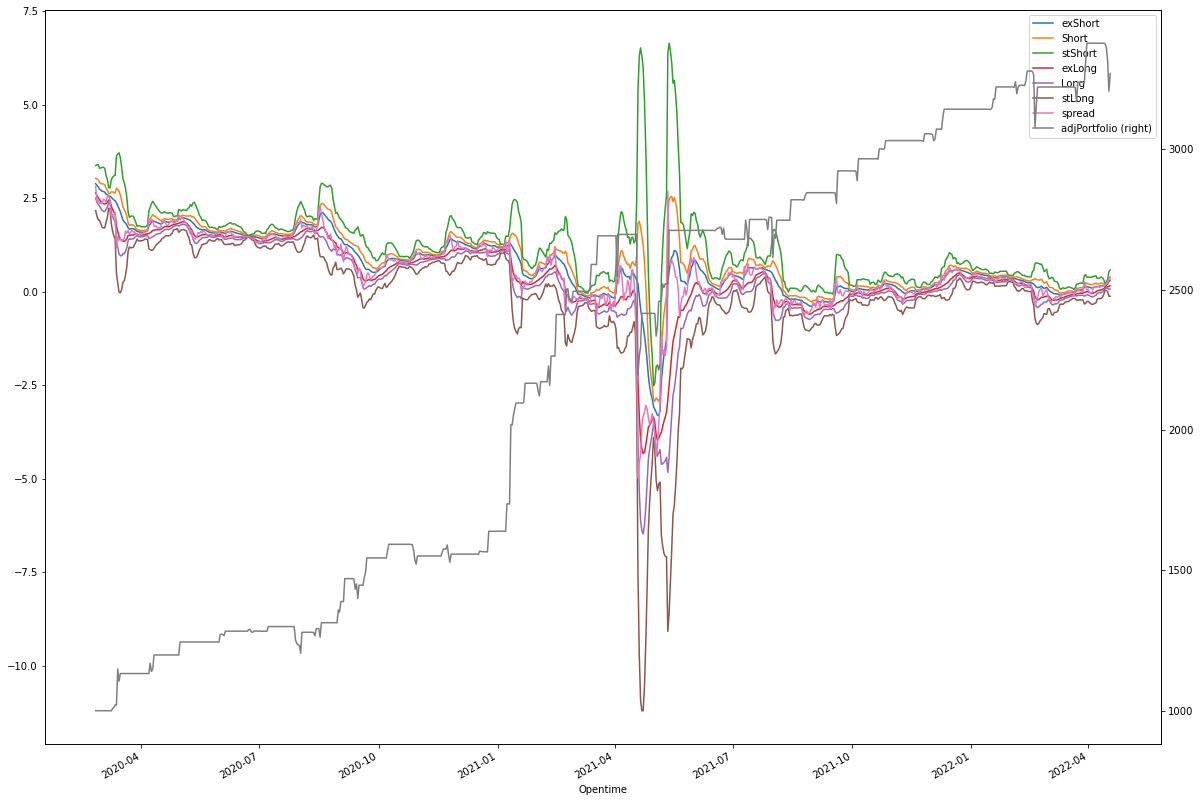

In [20]:
#graph of stratgey, grey line is portfolio over time
simul(signal([10, 1.8, 0.8, 4.0],xD,yD)).plot(y=["exShort","Short","stShort","exLong","Long","stLong","spread","adjPortfolio"],figsize = (20,15),secondary_y = "adjPortfolio")

In [18]:
xD = dataOrganizeDaily('EOSUSDT')
yD = dataOrganizeDaily('NEOUSDT')

In [13]:
sim = simul(signal([10, 1.8, 0.8, 4.0],xD,yD))
sim

,exShort,exLong,Short,Long,stShort,stLong,y,x,spread,hedge,xfr,yfr,ydiff,xdiff,portfolio,y_size,x_size,fee,adjPortfolio
Opentime,,,,,,,,,,,,,,,,,,,
2020-02-26,2.887398,2.646947,3.037680,2.496665,3.368300,2.166046,4.081,12.400,2.813116,0.102249,0.000300,0.000300,-0.045,-0.993,1000.000000,0.0,0.0,0.0,1000.000000
2020-02-27,2.840545,2.565508,3.012443,2.393610,3.390618,2.015434,3.539,10.999,2.414367,0.102249,0.000300,0.000300,-0.542,-1.401,1000.000000,0.0,0.0,0.0,1000.000000
2020-02-28,2.804037,2.507689,2.989255,2.322471,3.396734,1.914992,3.620,11.505,2.443629,0.102249,0.000300,0.000395,0.081,0.506,1000.000000,0.0,0.0,0.0,1000.000000
2020-02-29,2.740942,2.463040,2.914630,2.289352,3.296745,1.907237,3.516,11.310,2.359567,0.102249,0.000300,0.000552,-0.104,-0.195,1000.000000,0.0,0.0,0.0,1000.000000
2020-03-01,2.710898,2.412003,2.897708,2.225193,3.308689,1.814212,3.515,11.110,2.379017,0.102249,0.000300,0.000883,-0.001,-0.200,1000.000000,0.0,0.0,0.0,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-09,0.144713,0.035962,0.212682,-0.032007,0.362215,-0.181539,2.377,21.825,0.145423,0.102249,0.000213,0.000180,-0.125,-1.415,3487.581698,0.0,0.0,0.0,3377.879466
2022-04-10,0.148802,0.039249,0.217273,-0.029222,0.367909,-0.179857,2.415,22.537,0.110622,0.102249,0.000253,0.000188,0.038,0.712,3487.581698,0.0,0.0,0.0,3377.879466
2022-04-11,0.163120,0.046817,0.235809,-0.025872,0.395726,-0.185788,2.359,21.563,0.154212,0.102249,0.000198,0.000176,-0.056,-0.974,3487.581698,0.0,0.0,0.0,3377.879466


In [7]:
def getBinanceDataFuture(symbol, interval, start, end, limit=5000):
    df = pd.DataFrame()
    startDate = end
    prev = start
    while (startDate!=prev):
        prev = startDate
        url = 'https://fapi.binance.com/fapi/v1/klines?symbol=' + \
            symbol + '&interval=' + interval + '&endTime=' + str(startDate) 

        df2 = pd.read_json(url)
        df2.columns = ['Opentime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 'Quote asset volume', 'Number of trades','Taker by base', 'Taker buy quote', 'Ignore']
       
        df = pd.concat([df2, df], axis=0, ignore_index=True, keys=None)
        startDate = df.Opentime[0]
        
    df.reset_index(drop=True, inplace=True)  
    df['Opentime'] = pd.to_datetime(df['Opentime'],unit='ms')
    df = df.loc[1:]
    df = df[['Opentime', 'Open', 'High', 'Low', 'Close']]
    df = df.set_index('Opentime')
    df = df.drop_duplicates(keep=False)
    return df 

In [8]:
def getBinanceDataFundingRate(symbol, interval, start, end, limit=1000):
    df = pd.DataFrame()
    startDate = start
    prev = 0
    while (startDate!=prev):
        prev = startDate
        url = 'https://fapi.binance.com/fapi/v1/fundingRate?symbol=' + \
            symbol + '&startTime=' + str(startDate) + '&limit=' + str(limit)
     
        df2 = pd.read_json(url)
        df2.columns = ['symbol','fundingTime','fundingRate']
       
        df = pd.concat([df, df2], axis=0, ignore_index=True, keys=None)
        startDate = df2.fundingTime[len(df2)-1]
          
    df.reset_index(drop=True, inplace=True)  
    df['fundingTime'] = pd.to_datetime(df['fundingTime'],unit='ms')
    #df = df.loc[1:]
    #df = df.set_index('fundingTime')
    df = df.drop_duplicates(keep=False)
    df['fundingTime'] = df['fundingTime'].dt.floor('Min')
    df = df.set_index('fundingTime')
    return df 

In [9]:
def dataOrganizeDaily(ticker):
    fr =  getBinanceDataFundingRate(ticker,'1d',1458955882,current_milli_time())
    data = getBinanceDataFuture(ticker,'1d',1458955882,current_milli_time())
    date = fr.index.get_level_values('fundingTime').floor('D')
    dailyfr = fr.groupby([date]).sum().reset_index()
    dailyfr = dailyfr.set_index('fundingTime')
    data['fr'] = dailyfr['fundingRate']
    return data


In [10]:
def convertFRhourly(fr,price):
    fr["fundingRate"] = fr["fundingRate"]/8
    fr = fr.reindex(pd.date_range(price.index[0],price.index[-1],freq='1h'))
    fr = fr.ffill()
    price["fr"] = fr["fundingRate"]
    return price

In [11]:
def current_milli_time():
    return round(time.time() * 1000)

In [12]:
def signal(varaible,a,b):
    
    lookback,sdenter,sdexit,sdloss = varaible
    lookback = int(lookback)
    
    
    #merge data
    pairPrice = a.merge(b, left_index=True, right_index=True, how='left')
    pairPrice = pairPrice.dropna()

    reg = sm.OLS(pairPrice['Open_x'],pairPrice['Open_y']).fit()
    reg2 = sm.OLS(pairPrice['Open_y'],pairPrice['Open_x']).fit()
    
    #see which token should be a the dependent variable
    if adfuller(reg.resid)[1]<adfuller(reg2.resid)[1]:
        y = pairPrice['Open_x']
        x = pairPrice['Open_y']
        yfr = pairPrice['fr_x']
        xfr = pairPrice['fr_y']
        hedge = reg.params[0]
        spread = reg.resid
 
        
    else:
        y = pairPrice['Open_y']
        x = pairPrice['Open_x']
        xfr = pairPrice['fr_x']
        yfr = pairPrice['fr_y']
        hedge = reg2.params[0]
        spread = reg2.resid

    
    
   
    #enter 
    bands = pd.DataFrame(BBANDS(spread,timeperiod=lookback,nbdevup=sdenter,nbdevdn = sdenter,matype=1)).T
    bands = bands.set_index(pairPrice.index)
    bands.columns = ['Short','1mid','Long']
    
    #exit
    bands2 = pd.DataFrame(BBANDS(spread,timeperiod=lookback,nbdevup=sdexit,nbdevdn = sdexit,matype=1)).T
    bands2 = bands2.set_index(pairPrice.index)
    bands2.columns = ['exShort','mid','exLong']
    
    #stoploss
    bands3 = pd.DataFrame(BBANDS(spread,timeperiod=lookback,nbdevup=sdloss,nbdevdn = sdloss,matype=1)).T
    bands3 = bands3.set_index(pairPrice.index)
    bands3.columns = ['stShort','mid2','stLong']
    bbands = bands2.join(bands)
    bbands = bbands.join(bands3)
    bbands = bbands.drop(columns = ['mid','1mid','mid2'])
    
    bbands['y'] = y
    bbands['x'] = x
    bbands['spread'] = spread
    bbands['hedge'] =hedge
    bbands['xfr'] = xfr
    bbands['yfr'] = yfr
    
    bbands[['ydiff','xdiff']] = bbands[['y','x']].diff()
    bbands = bbands.dropna()

    
    
    return bbands

In [13]:
def simul(bbands):
    protfolio = []
    size = []
    fee = [] 
    cap = 1000
    position = np.array([0,0])

    for i in range(len(bbands)):
        #spread> short :
        if (position ==[0,0]).all():
            if (bbands["spread"].iloc[i]>bbands["Short"].iloc[i])&(bbands["spread"].iloc[i]<bbands["stShort"].iloc[i]):
                yp = bbands["y"].iloc[i]/(bbands["x"].iloc[i]*bbands["hedge"].iloc[i]+bbands["y"].iloc[i])
                xp = 1-yp
                position = np.array([-1*cap*yp/bbands['y'].iloc[i],1*cap*xp/bbands['x'].iloc[i]])
                commision = cap*((0.04/100))
                protfolio.append(cap)
                size.append(position)
                fee.append(commision)
                continue
                
            elif (bbands["spread"].iloc[i]<bbands["Long"].iloc[i]) & (bbands["spread"].iloc[i]>bbands["stLong"].iloc[i]):
                yp = bbands["y"].iloc[i]/(bbands["x"].iloc[i]*bbands["hedge"].iloc[i]+bbands["y"].iloc[i])
                xp = 1-yp
                position = np.array([1*cap*yp/bbands['y'].iloc[i],-1*cap*xp/bbands['x'].iloc[i]])
                commision = cap*((0.04/100))
                protfolio.append(cap)
                size.append(position)
                fee.append(commision)
                continue
            else:
                protfolio.append(cap)
                size.append(position)
                fee.append(0)
                continue
        elif (np.sign(position)==[-1,1]).all():
            if (bbands["spread"].iloc[i]<bbands["exShort"].iloc[i])|(bbands["spread"].iloc[i]>bbands["stShort"].iloc[i]):
                cap = cap + (position*np.array((bbands["ydiff"].iloc[i],bbands["xdiff"].iloc[i]))).sum()
                commision = cap*((0.04/100))
                position = np.array([0,0])
                protfolio.append(cap)
                size.append(position)
                fee.append(commision)
                continue
            else:
                cap = cap + (position*np.array((bbands["ydiff"].iloc[i],bbands["xdiff"].iloc[i]))).sum()
                long = position[1]*bbands["x"][i]
                short = cap- long
                fundingRate = short*bbands["yfr"][i]-long*bbands["xfr"][i]
                protfolio.append(cap)
                size.append(position)
                fee.append(fundingRate)
                continue
        else:
            if (bbands["spread"].iloc[i]>bbands["exLong"].iloc[i])|(bbands["spread"].iloc[i]<bbands["stLong"].iloc[i]):
                cap = cap + (position*np.array((bbands["ydiff"].iloc[i],bbands["xdiff"].iloc[i]))).sum()
                commision = cap*((0.04/100))
                position = np.array([0,0])
                protfolio.append(cap)
                size.append(position)
                fee.append(commision)
                continue
            else:
                cap = cap + (position*np.array((bbands["ydiff"].iloc[i],bbands["xdiff"].iloc[i]))).sum()
                long = position[0]*bbands["y"][i]
                short = cap- long
                fundingRate = short*bbands["xfr"][i]-long*bbands["yfr"][i]
                protfolio.append(cap)
                size.append(position)
                fee.append(fundingRate)
                continue

            
    bbands["portfolio"] = protfolio
    bbands[["y_size","x_size"]] = size

    
    bbands["fee"] = fee
    bbands["adjPortfolio"] = protfolio- bbands["fee"].cumsum()
    
    return bbands

In [14]:
sim[(sim['y_size'].diff()!=0)]

NameError: name 'sim' is not defined

In [15]:
def sharpe(sim):
    daily_ret = sim["adjPortfolio"].pct_change()
    sharpe = math.sqrt(365)*daily_ret.mean()/daily_ret.std()
    return sharpe    

In [100]:
def winRate(sim):
    indeTrade = sim[(sim['y_size'].diff()!=0)].iloc[::2]['adjPortfolio'].diff()[1:]
    return np.sign(indeTrade).sum()/len(indeTrade)

In [111]:
def avgWin(sim):
    indeTrade = sim[(sim['y_size'].diff()!=0)].iloc[::2]['adjPortfolio'].pct_change()[1:]
    return indeTrade[indeTrade>0].mean()

In [112]:
def avgLoss(sim):
    indeTrade = sim[(sim['y_size'].diff()!=0)].iloc[::2]['adjPortfolio'].pct_change()[1:]
    return indeTrade[indeTrade<0].mean()

In [179]:
def totalRet(sim):
    return str(str(round((sim['adjPortfolio'][-1]/sim['adjPortfolio'][0])*100,2))+"% over "+str((sim.index[-1]-sim.index[0]).days)+" days")

In [228]:
def avgTimeBetweenTrade(sim):
    time_p1_cr = sim[(sim['y_size'].diff()!=0)].index
    differences = np.array([(t2 - t1).days for t1,t2 in zip(time_p1_cr[:-1], time_p1_cr[1:])])[::2]
    return str(round(differences.mean(),2))+" days"

In [230]:
def avgHoldingTime(sim):
    time_p1_cr = sim[(sim['y_size'].diff()!=0)].index
    differences = np.array([(t2 - t1).days for t1,t2 in zip(time_p1_cr[:-1], time_p1_cr[1:])])[1:][::2]
    return str(round(differences.mean(),2))+" days"

In [246]:
def cointTest(sim):
    x=sim['x']
    y=sim['y']
    return str(round(min(coint(x,y)[1],coint(y,x)[1]),6))+" p-value"

In [248]:
def performanceStat(sim):
    sharpe_ratio = round(sharpe(sim),3)
    win_ratio =round(winRate(sim),3)
    avg_win = round(avgWin(sim),4)
    avg_loss = round(avgLoss(sim),4)
    ret = totalRet(sim)
    dd = round(max_drawdown(sim['adjPortfolio'].pct_change()),3)
    avgTime = avgTimeBetweenTrade(sim)
    avgHold = avgHoldingTime(sim)
    cointer = cointTest(sim)
    return {"Total Return":ret,"Sharpe Ratio":sharpe_ratio,"Win Ratio":win_ratio,"avg_win":avg_win,"avg_loss":avg_loss,"Max DrawDown":dd,"Average Time Between Trade":avgTime,"Average Hold Time":avgHold,"Cointergration Test":cointer}

In [249]:
performanceStat(sim)

{'Total Return': '352.6% over 772 days',
 'Sharpe Ratio': 2.275,
 'Win Ratio': 0.695,
 'avg_win': 0.0303,
 'avg_loss': -0.0226,
 'Max DrawDown': -0.185,
 'Average Time Between Trade': '10.32 days',
 'Average Hold Time': '2.63 days',
 'Cointergration Test': '0.003774 p-value'}